Credit_Limit_Analysis_Plan.ipynb

Automatically generated by Colab.

# Kế hoạch Phân tích Dữ liệu: Xây dựng Mô hình Hồi quy Tuyến tính Dự báo Hạn mức Tín dụng

## 1. Cài đặt và Nhập Thư viện


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Đã nhập xong các thư viện cần thiết.")


Đã nhập xong các thư viện cần thiết.


## 2. Mô tả và Chuẩn bị Dữ liệu (Data Simulation & Preparation)

### 2.1 & 2.2 Tạo Dữ liệu Giả lập
Tạo 300 quan sát dựa trên phương trình tuyến tính ngầm định (Ground Truth).


In [9]:
# Thiết lập hạt giống ngẫu nhiên để tái lập kết quả
np.random.seed(42)
n = 300

# --- Biến độc lập (X) ---
# Monthly_Income: Trung bình 5500, độ lệch 2000
income = np.random.normal(5500, 2000, n).clip(1500, 20000)

# Credit_Score: Trung bình 700, độ lệch 50
credit_score = np.random.normal(700, 50, n).clip(300, 850)

# Is_Homeowner: 0 hoặc 1
is_homeowner = np.random.choice([0, 1], n)

# Education_Level: 4 cấp độ
edu_levels = ['High School', 'Undergraduate', 'Graduate', 'Professional']
education = np.random.choice(edu_levels, n, p=[0.25, 0.4, 0.25, 0.1])

# Tạo DataFrame
df = pd.DataFrame({
    'Monthly_Income': income,
    'Credit_Score': credit_score,
    'Is_Homeowner': is_homeowner,
    'Education_Level': education
})

# --- Xử lý biến (Feature Engineering) ---
# 1. Dummy Variables: Chuyển Education thành số, drop_first=True (High School là tham chiếu)
# FIX 1: Định nghĩa thứ tự Category để đảm bảo 'High School' đứng đầu
df['Education_Level'] = pd.Categorical(df['Education_Level'], 
                                       categories=['High School', 'Undergraduate', 'Graduate', 'Professional'], 
                                       ordered=True)

# FIX 2: Thêm dtype=int để đảm bảo output là 0/1 (int) thay vì True/False (bool) gây lỗi statsmodels
df_dummies = pd.get_dummies(df['Education_Level'], prefix='Edu', drop_first=True, dtype=int)

# 2. Tạo Biến Phụ Thuộc (Y) - Credit_Limit
noise = np.random.normal(0, 800, n) # Nhiễu ngẫu nhiên

# Công thức: Y = -20000 + 1.8*Income + 30*Score + 3000*Home + Dummies + Noise
y = (
    -20000 +
    (df['Monthly_Income'] * 1.8) +
    (df['Credit_Score'] * 30) +
    (df['Is_Homeowner'] * 3000) +
    (df_dummies.get('Edu_Undergraduate', 0) * 1500) +
    (df_dummies.get('Edu_Graduate', 0) * 4000) +
    (df_dummies.get('Edu_Professional', 0) * 8000) +
    noise
)

df['Credit_Limit'] = y.round(2)

# Gộp dummies vào DF chính
df_final = pd.concat([df, df_dummies], axis=1)

print("--- 5 Dòng đầu tiên của dữ liệu giả lập ---")
print(df_final.head())


--- 5 Dòng đầu tiên của dữ liệu giả lập ---
   Monthly_Income  Credit_Score  Is_Homeowner Education_Level  Credit_Limit  Edu_Undergraduate  Edu_Graduate  Edu_Professional
0     6493.428306    658.550249             0   Undergraduate      11724.26                  1             0                 0
1     5223.471398    671.990948             1   Undergraduate      13508.45                  1             0                 0
2     6795.377076    737.364680             1   Undergraduate      18816.15                  1             0                 0
3     8546.059713    730.518513             0   Undergraduate      18993.13                  1             0                 0
4     5031.693251    698.954920             1     High School      12832.71                  0             0                 0


### 2.3 Kỹ thuật Xử lý Biến: PCA (Principal Component Analysis)
Áp dụng PCA cho `Monthly_Income` và `Credit_Score` để xử lý đa cộng tuyến tiềm năng.


In [10]:
# Chọn biến số để PCA
cols_for_pca = ['Monthly_Income', 'Credit_Score']

# Bước 1: Chuẩn hóa (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_final[cols_for_pca])

# Bước 2: Áp dụng PCA (2 thành phần)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Thêm PC1, PC2 vào DataFrame
df_final['PC1'] = principal_components[:, 0]
df_final['PC2'] = principal_components[:, 1]

print("\n--- Kết quả PCA ---")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
print("PC1 giải thích phần lớn phương sai kết hợp giữa Thu nhập và Điểm tín dụng.")



--- Kết quả PCA ---
Explained Variance Ratio: [0.51619424 0.48380576]
PC1 giải thích phần lớn phương sai kết hợp giữa Thu nhập và Điểm tín dụng.


## 3. Phân tích Dữ liệu Khám phá (EDA)

### 3.1 Phân tích Phân phối (Histograms)


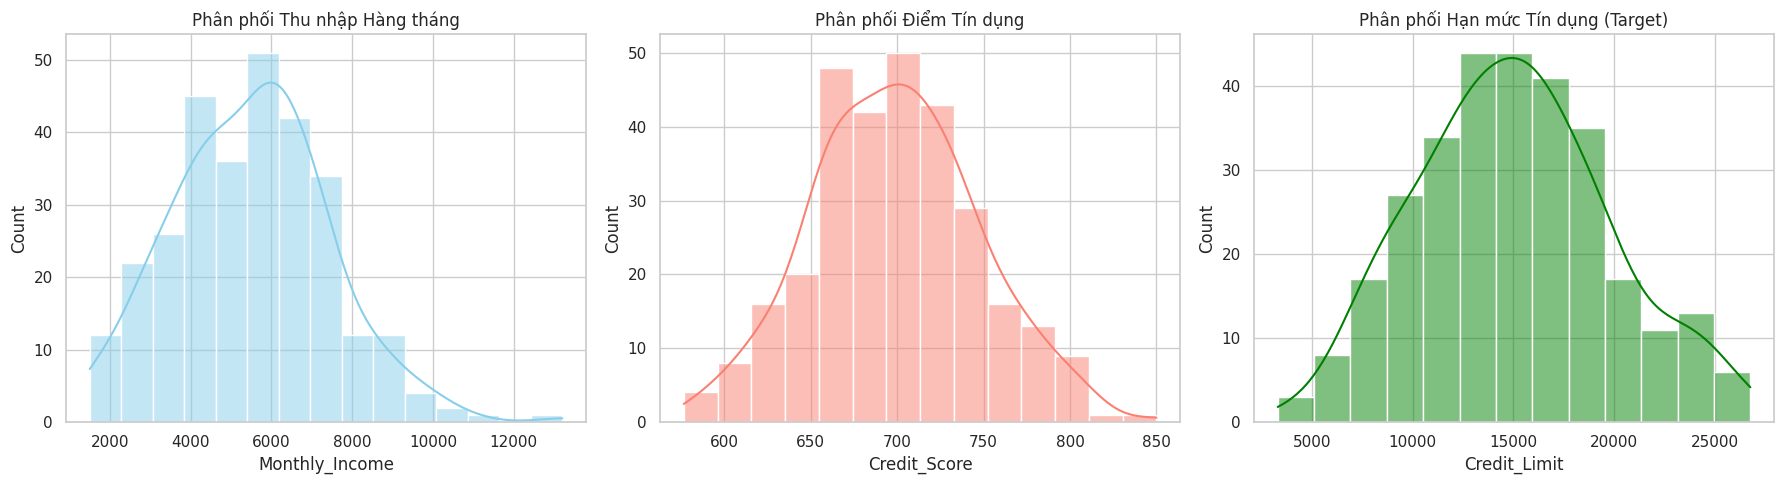

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_final['Monthly_Income'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Phân phối Thu nhập Hàng tháng')

sns.histplot(df_final['Credit_Score'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Phân phối Điểm Tín dụng')

sns.histplot(df_final['Credit_Limit'], kde=True, ax=axes[2], color='green')
axes[2].set_title('Phân phối Hạn mức Tín dụng (Target)')

plt.tight_layout()
plt.show()


### 3.2 Phân tích Mối quan hệ (Scatterplot Matrix)


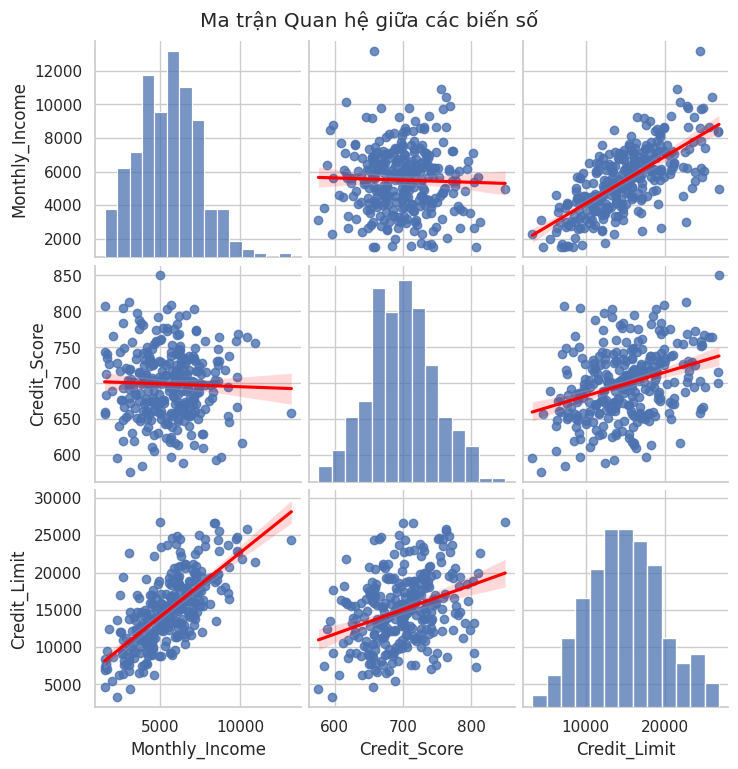

In [12]:
# Chọn các biến chính để vẽ
cols_to_plot = ['Monthly_Income', 'Credit_Score', 'Credit_Limit']
sns.pairplot(df_final[cols_to_plot], kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Ma trận Quan hệ giữa các biến số', y=1.02)
plt.show()


### 3.3 Phát hiện Ngoại lệ (Box Plots)


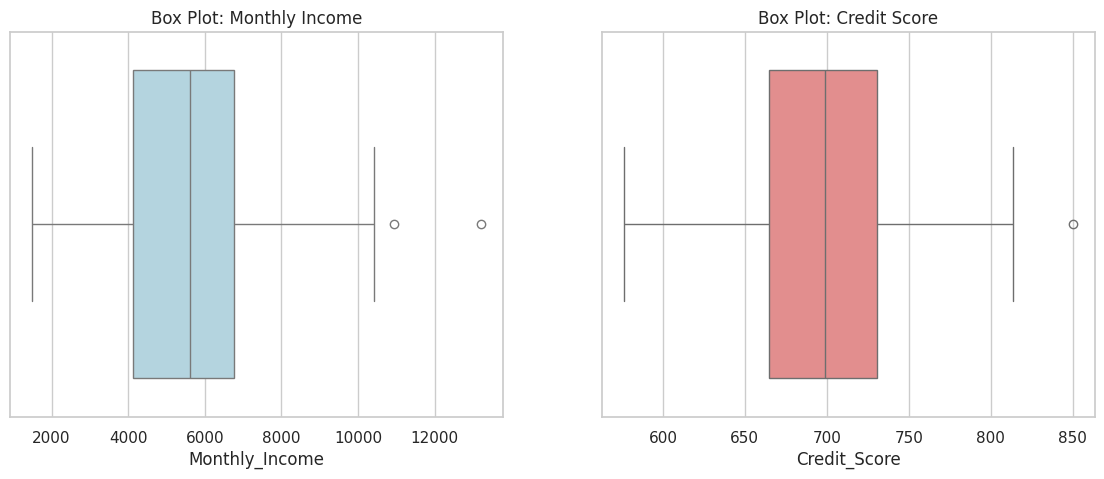

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x=df_final['Monthly_Income'], ax=axes[0], color='lightblue')
axes[0].set_title('Box Plot: Monthly Income')

sns.boxplot(x=df_final['Credit_Score'], ax=axes[1], color='lightcoral')
axes[1].set_title('Box Plot: Credit Score')
plt.show()


## 4. Xây dựng và Phân tích Mô hình

### 4.1 Xây dựng hai Mô hình (A và B)
Sử dụng `statsmodels` để có báo cáo thống kê đầy đủ.


In [14]:
# --- MÔ HÌNH A (Cơ sở) ---
# Biến độc lập: Income, Score, Homeowner, Dummies học vấn
X_A = df_final[['Monthly_Income', 'Credit_Score', 'Is_Homeowner', 
                'Edu_Undergraduate', 'Edu_Graduate', 'Edu_Professional']]

# FIX 3: Ép kiểu dữ liệu sang float để tránh lỗi object/boolean trong statsmodels
X_A = X_A.astype(float)
X_A = sm.add_constant(X_A) # Thêm hệ số chặn (Intercept)
Y = df_final['Credit_Limit']

model_a = sm.OLS(Y, X_A).fit()

# --- MÔ HÌNH B (PCA) ---
# Biến độc lập: PC1, PC2, Homeowner, Dummies học vấn
X_B = df_final[['PC1', 'PC2', 'Is_Homeowner', 
                'Edu_Undergraduate', 'Edu_Graduate', 'Edu_Professional']]
X_B = X_B.astype(float) # Ép kiểu sang float
X_B = sm.add_constant(X_B)
Y = df_final['Credit_Limit']

model_b = sm.OLS(Y, X_B).fit()

print("Đã xây dựng xong 2 mô hình.")


Đã xây dựng xong 2 mô hình.


### 4.2 Phân tích Kết quả

#### Kiểm tra Đa cộng tuyến (cho Mô hình A)


In [15]:
# Ma trận tương quan
corr_matrix = df_final[['Monthly_Income', 'Credit_Score']].corr()
print("--- Ma trận Tương quan (Income vs Score) ---")
print(corr_matrix)
print("\nNhận xét: Nếu hệ số tương quan gần 0 (do dữ liệu giả lập ngẫu nhiên), đa cộng tuyến thấp.")
print("Trong thực tế, Income và Score thường tương quan cao (>0.7), khi đó PCA (Mô hình B) sẽ cần thiết hơn.")

#### Kết quả Tóm tắt (Summary Output)
print("\n" + "="*30)
print("KẾT QUẢ MÔ HÌNH A (BASE MODEL)")
print("="*30)
print(model_a.summary())

print("\n" + "="*30)
print("KẾT QUẢ MÔ HÌNH B (PCA MODEL)")
print("="*30)
print(model_b.summary())


--- Ma trận Tương quan (Income vs Score) ---
                Monthly_Income  Credit_Score
Monthly_Income        1.000000     -0.032388
Credit_Score         -0.032388      1.000000

Nhận xét: Nếu hệ số tương quan gần 0 (do dữ liệu giả lập ngẫu nhiên), đa cộng tuyến thấp.
Trong thực tế, Income và Score thường tương quan cao (>0.7), khi đó PCA (Mô hình B) sẽ cần thiết hơn.

KẾT QUẢ MÔ HÌNH A (BASE MODEL)
                            OLS Regression Results                            
Dep. Variable:           Credit_Limit   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1633.
Date:                Mon, 05 Jan 2026   Prob (F-statistic):          6.91e-222
Time:                        16:38:29   Log-Likelihood:                -2435.3
No. Observations:                 300   AIC:                             4885.
Df Residuals:                     293   BI

### 4.3 Phân tích Phần dư (Residual Analysis)
Vẽ 4 biểu đồ chẩn đoán cho Mô hình A (Mô hình dễ diễn giải hơn).


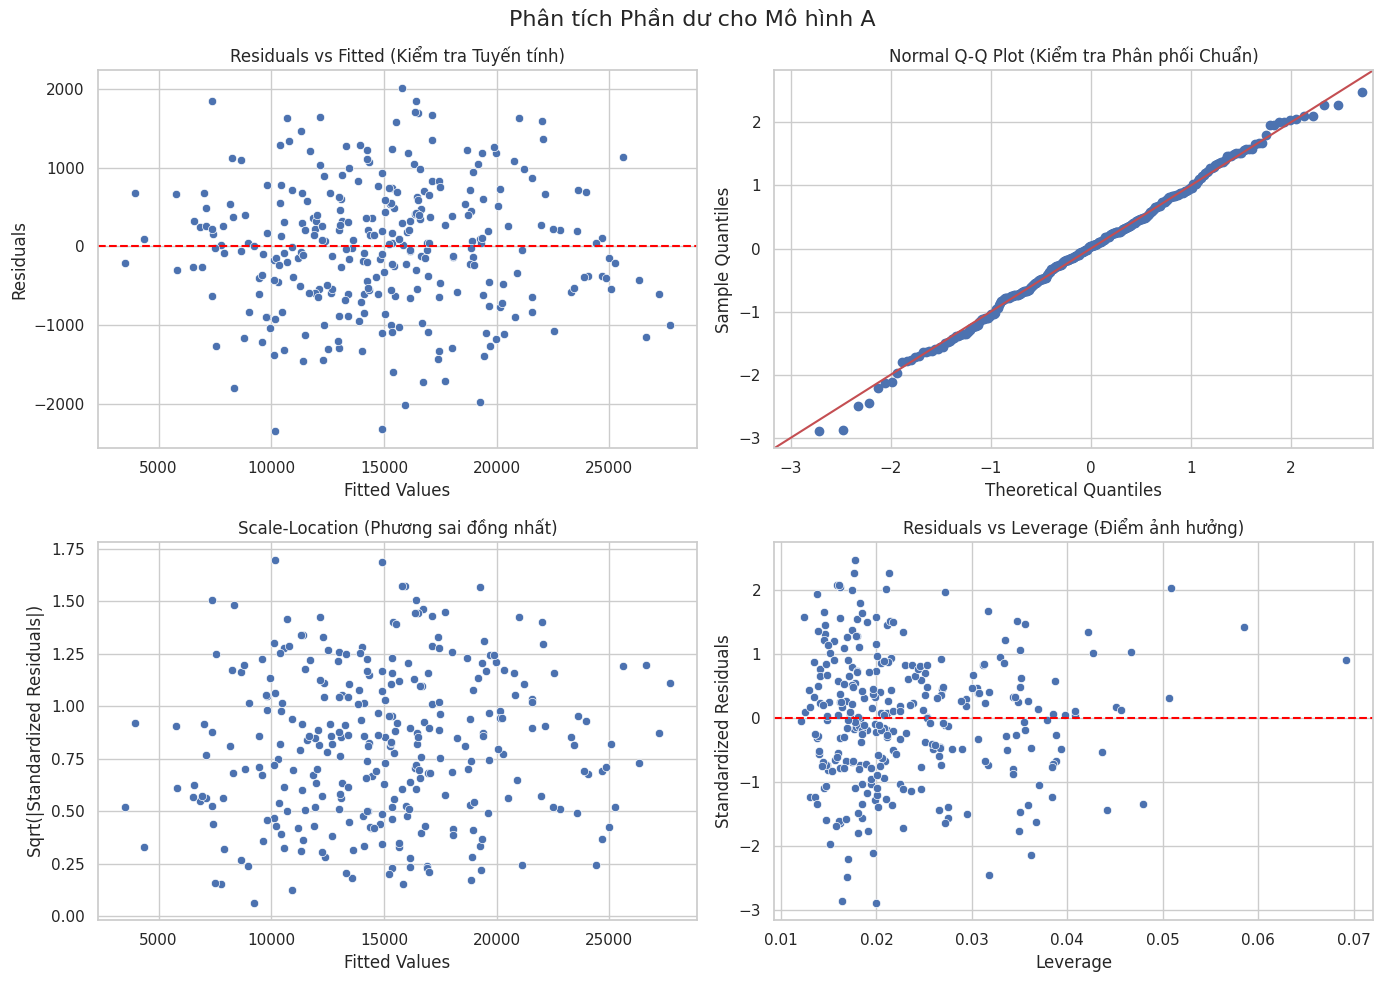

In [16]:
residuals = model_a.resid
fitted = model_a.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.suptitle('Phân tích Phần dư cho Mô hình A', fontsize=16)

# 1. Residuals vs Fitted
sns.scatterplot(x=fitted, y=residuals, ax=axes[0, 0])
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Kiểm tra Tuyến tính)')

# 2. Normal Q-Q Plot
sm.qqplot(residuals, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot (Kiểm tra Phân phối Chuẩn)')

# 3. Scale-Location (Homoscedasticity)
# Căn bậc 2 của trị tuyệt đối residuals đã chuẩn hóa
model_norm_residuals = model_a.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
sns.scatterplot(x=fitted, y=model_norm_residuals_abs_sqrt, ax=axes[1, 0])
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('Sqrt(|Standardized Residuals|)')
axes[1, 0].set_title('Scale-Location (Phương sai đồng nhất)')

# 4. Residuals vs Leverage
# Sử dụng influence plot của statsmodels hoặc vẽ thủ công cook's distance
# Ở đây vẽ Leverage vs Standardized Residuals đơn giản
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(model_a)
leverage = influence.hat_matrix_diag
sns.scatterplot(x=leverage, y=model_norm_residuals, ax=axes[1, 1])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Leverage')
axes[1, 1].set_ylabel('Standardized Residuals')
axes[1, 1].set_title('Residuals vs Leverage (Điểm ảnh hưởng)')

plt.tight_layout()
plt.show()


## 5. Tổng kết và Hướng phát triển

### So sánh nhanh


In [17]:
adj_r2_a = model_a.rsquared_adj
adj_r2_b = model_b.rsquared_adj

print("--- SO SÁNH HIỆU SUẤT ---")
print(f"Adjusted R-squared (Mô hình A - Gốc): {adj_r2_a:.4f}")
print(f"Adjusted R-squared (Mô hình B - PCA): {adj_r2_b:.4f}")

if adj_r2_a >= adj_r2_b:
    print("\nKết luận: Mô hình A có hiệu suất tương đương hoặc tốt hơn và dễ diễn giải hơn.")
    print("Khuyến nghị: Sử dụng Mô hình A để giải thích cho các bên liên quan (Stakeholders).")
else:
    print("\nKết luận: Mô hình B giải thích biến thiên tốt hơn.")
    print("Khuyến nghị: Xem xét Mô hình B nếu độ chính xác dự báo là ưu tiên hàng đầu, chấp nhận khó diễn giải biến PC1/PC2.")


--- SO SÁNH HIỆU SUẤT ---
Adjusted R-squared (Mô hình A - Gốc): 0.9704
Adjusted R-squared (Mô hình B - PCA): 0.9704

Kết luận: Mô hình A có hiệu suất tương đương hoặc tốt hơn và dễ diễn giải hơn.
Khuyến nghị: Sử dụng Mô hình A để giải thích cho các bên liên quan (Stakeholders).
